In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import imutils
from imutils import paths
import pylab as pl
import numpy as np
import random
import cv2
import os

In [4]:
from lenet import LeNet

---

To start with we need to **train** our machine learning model.

To train the machine learning model for the CNN we first need to tell the code where to find the input training data.

In [5]:
dataset1 = '../../santa/'
dataset2 = '../../notsanta/'

Then specify a filename for where we're going to store the trained machine learning model we're going to make:

In [6]:
modelname = './santa_model'

Next define parameters to initialize the number of epochs to train for and the batch size:

In [7]:
EPOCHS = 25
BS = 32

Then set the initial learning rate:

In [8]:
INIT_LR = 1e-3

We need to read all of the data into data arrays - and to make a corresponding array of labels for those data.

In [9]:
data = []
labels = []

We want to make sure that the data are in a completely random order, so we'll shuffle all the data as we read it in.

In [10]:
imagePaths = sorted(list(paths.list_images(dataset1))+list(paths.list_images(dataset2)))
random.seed(42)
random.shuffle(imagePaths)

Training is computationally expensive, so we'll resize all our data and make the images a bit smaller. They all also need to be the same size.

In [11]:
for imagePath in imagePaths:
    
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    label = 1 if label == "santa" else 0
    labels.append(label)

Re-scale the image array values to lie within the interval [0,1]:

In [12]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

We're going to partition the data into training and testing splits. Here we're using 75% of the data for training and the remaining 25% for testing. We can use the scikit-learn function train_test_split to divide up our dataset into training and validation sets. The training_size is automatically *1 - test_size*.

In [13]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

Then convert the labels from integers to vectors:

In [14]:
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

We don't have a huge amount of data, so we'll augment the training dataset by rotating, shifting and generally jiggling the data that we have.

In [15]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

Now let's build the machine learning model from LeNet.

Our images have *height x width = 28 x 28* and they are RGB images which means that they have *3 channels*.

In [16]:
model = LeNet.build(width=28, height=28, chan=3, classes=2)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Then train the network:

In [17]:
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS), validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS, verbose=1)

Epoch 1/25
15/15 [==============================] - 2s 101ms/step - loss: 0.7058 - acc: 0.5729 - val_loss: 0.7636 - val_acc: 0.4233
Epoch 2/25
15/15 [==============================] - 1s 60ms/step - loss: 0.6881 - acc: 0.5499 - val_loss: 0.6548 - val_acc: 0.5706
Epoch 3/25
15/15 [==============================] - 1s 65ms/step - loss: 0.6575 - acc: 0.6464 - val_loss: 0.6223 - val_acc: 0.7607
Epoch 4/25
15/15 [==============================] - 1s 61ms/step - loss: 0.5761 - acc: 0.7176 - val_loss: 0.7731 - val_acc: 0.6074
Epoch 5/25
15/15 [==============================] - 1s 76ms/step - loss: 0.5398 - acc: 0.7113 - val_loss: 0.5156 - val_acc: 0.7791
Epoch 6/25
15/15 [==============================] - 1s 66ms/step - loss: 0.5239 - acc: 0.7510 - val_loss: 0.5921 - val_acc: 0.6564
Epoch 7/25
15/15 [==============================] - 1s 63ms/step - loss: 0.4725 - acc: 0.7866 - val_loss: 0.4639 - val_acc: 0.7853
Epoch 8/25
15/15 [==============================] - 1s 64ms/step - loss: 0.5008 - 

Training machine learning models is expensive computationally, so we don't want to have to keep repeating this step. Instead we can save our trained model and reload it whenever we need to use it.

In [18]:
model.save(modelname)

We can visualise the success of the training by looking at the variation in accuracy and loss as a function of epoch.

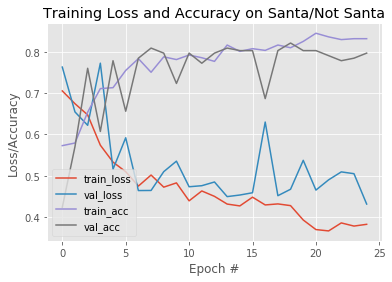

In [ ]:
pl.style.use("ggplot")
pl.figure()
N = EPOCHS
pl.plot(np.arange(0, N), H.history["loss"], label="train_loss")
pl.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
pl.plot(np.arange(0, N), H.history["acc"], label="train_acc")
pl.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
pl.title("Training Loss and Accuracy on Santa/Not Santa")
pl.xlabel("Epoch #")
pl.ylabel("Loss/Accuracy")
pl.legend(loc="lower left")
pl.savefig("output.png")

---

Now let's see how we did... (well, actually our accuracy already tells us how well we did, but it's nice to see the network in practice).

We feed our network a test image,

In [ ]:
testimage="../../santa/00000171.jpg"

We need to apply the same pre-processing to this test image as we did with our training data:

In [ ]:
# pre-process the image for classification
image = cv2.imread(testimage)
orig = image.copy()
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

We can now use the machine learning model to predict the class of this image. The output is a pair of probabilities, which represent the likelihood of the image being Santa or Not Santa. Normally the class is decided based on whichever is larger.

In [ ]:
(notSanta, santa) = model.predict(image)[0]

We can then implement the classification.

In [ ]:
label = "Santa" if santa > notSanta else "Not Santa"
proba = santa if santa > notSanta else notSanta
label = "{}: {:.2f}%".format(label, proba * 100)

In [ ]:
output = imutils.resize(orig, width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

array([[[249, 190, 154],
        [252, 202, 162],
        [254, 216, 175],
        ...,
        [255, 255, 246],
        [255, 255, 245],
        [255, 255, 245]],

       [[250, 209, 165],
        [249, 203, 156],
        [254, 220, 184],
        ...,
        [255, 255, 248],
        [255, 255, 247],
        [255, 255, 245]],

       [[232, 182, 138],
        [241, 188, 145],
        [238, 177, 145],
        ...,
        [255, 255, 245],
        [255, 255, 245],
        [255, 255, 245]],

       ...,

       [[255, 218, 179],
        [255, 218, 181],
        [254, 217, 179],
        ...,
        [254, 229, 204],
        [255, 229, 203],
        [254, 227, 201]],

       [[255, 216, 177],
        [254, 216, 177],
        [254, 214, 177],
        ...,
        [254, 228, 202],
        [255, 227, 201],
        [255, 226, 200]],

       [[254, 213, 174],
        [255, 212, 171],
        [254, 213, 173],
        ...,
        [255, 227, 199],
        [255, 225, 200],
        [255, 225, 200]]

In [ ]:
cv2.imshow("Output", output)
cv2.waitKey(0)